<a href="https://colab.research.google.com/github/Ryan0v0/nninn/blob/master/vq_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip3 install -U -r requirements.txt

# Step1: Splitting up neural net params into chunks

In [3]:
import torch
import torch.nn as nn

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

        # Initialize the weights to be non-negative
        nn.init.uniform_(self.fc1.weight, a=0, b=1)
        nn.init.uniform_(self.fc2.weight, a=0, b=1)
        nn.init.uniform_(self.fc3.weight, a=0, b=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = NeuralNetwork()

# Split up the neural network parameters into chunks
chunk_size = 1000
param_chunks = []
for param in net.parameters():
    flattened_param = param.view(-1)
    chunks = torch.split(flattened_param, chunk_size)
    param_chunks.extend(chunks)

# Print the number of parameter chunks
print("Number of parameter chunks:", len(param_chunks))
# print("Parameter chunks:", param_chunks)


Number of parameter chunks: 15


In [4]:
import numpy as np

# Convert param_chunks to a numpy array
param_chunks_np = np.concatenate([chunk.detach().numpy() for chunk in param_chunks])

print(type(param_chunks_np))
print("size:", param_chunks_np.shape)

<class 'numpy.ndarray'>
size: (11301,)


# Step2: learning a mapping from each chunk to an integer via VQ-VAE

In [5]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Load Data

using the weights of the above neural network as input.

In [7]:
data_variance = np.var(param_chunks_np / 255.0)

print(data_variance)

1.3580712e-06


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        '''
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        '''
        # convert inputs from HW -> HW
        inputs = inputs.permute(0, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [9]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 1).contiguous() # (0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [10]:

class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(in_features=in_channels,
                      out_features=num_residual_hiddens),
            nn.ReLU(True),
            nn.Linear(in_features=num_residual_hiddens,
                      out_features=num_hiddens) # Replaced with nn.Linear
        )

    def forward(self, x):
        return x + self._block(x)
        # x = x.unsqueeze(2)  # Add an extra dimension
        # output = x + self._block(x)
        # return output.squeeze(2)  # Remove the extra dimension

'''
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels, out_channels=num_residual_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        x = x.unsqueeze(2)  # Add an extra dimension
        output = x + self._block(x)
        return output.squeeze(2)  # Remove the extra dimension
'''
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels*64, num_hiddens//2)
        self._linear_2 = nn.Linear(num_hiddens//2, num_hiddens)


        self._residual_stack = ResidualStack(in_channels=128, #num_hiddens,
                                             num_hiddens=1,
                                             num_residual_layers=1,
                                             num_residual_hiddens=1)


    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1))
        print("x=", x.shape)
        x = F.relu(x)

        x = self._linear_2(x)
        x = F.relu(x)

        return self._residual_stack(x)

In [12]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels, num_hiddens)

        self._residual_stack = ResidualStack(in_channels=128, #num_hiddens,
                                             num_hiddens=1,
                                             num_residual_layers=1,
                                             num_residual_hiddens=1)

        self._linear_2 = nn.Linear(num_hiddens, num_hiddens//2)

    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1))
        # print("x=", x.shape)
        x = self._residual_stack(x)

        x = self._linear_2(x)
        x = F.relu(x)

        return x

## Train

We use the hyperparameters from the author's code:

In [13]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset from param_chunks_np
dataset = TensorDataset(torch.from_numpy(param_chunks_np))

# Set the batch size and other DataLoader parameters
batch_size = 64
shuffle = True
pin_memory = True

# Create the DataLoader using the custom dataset
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
data = next(iter(training_loader))
data = torch.stack(data).to(device)

In [15]:
cifar_training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

cifar_training_loader = DataLoader(cifar_training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

(data, _) = next(iter(cifar_training_loader))
data = data.to(device)

Files already downloaded and verified


In [16]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        # Updated input size to [1, 64]
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        print(self._encoder)

        # Replaced with nn.Linear
        self._pre_vq_linear = nn.Linear(num_hiddens, embedding_dim)

        print(self._pre_vq_linear)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        print(self._vq_vae)

        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        print(self._decoder)

    def forward(self, x):
        z = self._encoder(x)
        z = z.view(z.size(0), -1)  # Flatten the tensor
        z = self._pre_vq_linear(z)

        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        # x_recon = 0
        return loss, x_recon, perplexity

In [17]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

Encoder(
  (_linear_1): Linear(in_features=64, out_features=64, bias=True)
  (_linear_2): Linear(in_features=64, out_features=128, bias=True)
  (_residual_stack): ResidualStack(
    (_layers): ModuleList(
      (0): Residual(
        (_block): Sequential(
          (0): ReLU(inplace=True)
          (1): Linear(in_features=128, out_features=1, bias=True)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
  )
)
Linear(in_features=128, out_features=64, bias=True)
VectorQuantizerEMA(
  (_embedding): Embedding(512, 64)
)
Decoder(
  (_linear_1): Linear(in_features=64, out_features=128, bias=True)
  (_residual_stack): ResidualStack(
    (_layers): ModuleList(
      (0): Residual(
        (_block): Sequential(
          (0): ReLU(inplace=True)
          (1): Linear(in_features=128, out_features=1, bias=True)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
 

In [18]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [19]:
model.train()

Model(
  (_encoder): Encoder(
    (_linear_1): Linear(in_features=64, out_features=64, bias=True)
    (_linear_2): Linear(in_features=64, out_features=128, bias=True)
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Linear(in_features=128, out_features=1, bias=True)
            (2): ReLU(inplace=True)
            (3): Linear(in_features=1, out_features=1, bias=True)
          )
        )
      )
    )
  )
  (_pre_vq_linear): Linear(in_features=128, out_features=64, bias=True)
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_linear_1): Linear(in_features=64, out_features=128, bias=True)
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Linear(in_features=128, out_features=1, bias=True)
 

## Tokenization Output

In [20]:
model.eval()

data = next(iter(training_loader))
train_originals = torch.stack(data).to(device)
vq_output_eval = model._pre_vq_linear(model._encoder(train_originals))
print("vq_output_eval=", vq_output_eval)
print("vq_output_eval.shape=", vq_output_eval.shape)
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
print(valid_quantize)
print("valid_quantize=", valid_quantize)
print("valid_quantize.shape=", valid_quantize.shape)
valid_reconstructions = model._decoder(valid_quantize)

x= torch.Size([1, 64])
vq_output_eval= tensor([[-0.0226,  0.0553,  0.0072,  0.0554, -0.0503,  0.0721, -0.0739, -0.0686,
         -0.0521,  0.0695,  0.0535, -0.0215,  0.0245,  0.0329,  0.0499,  0.0470,
          0.0153,  0.0074, -0.0805,  0.0336,  0.0758, -0.0366, -0.0881,  0.0197,
          0.0781,  0.0738, -0.0585, -0.0375, -0.0020,  0.0396, -0.0657,  0.0336,
         -0.0466,  0.0026, -0.0411,  0.0302, -0.0767,  0.0041,  0.0274, -0.0274,
         -0.0293,  0.0523, -0.0525, -0.0084,  0.0741, -0.0214,  0.0642,  0.0322,
          0.0188,  0.0557, -0.0629,  0.0315,  0.0312,  0.0126, -0.0788,  0.0150,
          0.0250,  0.0125,  0.0661, -0.0430, -0.0037, -0.0273,  0.0673, -0.0777]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
vq_output_eval.shape= torch.Size([1, 64])
tensor([[-0.8677,  1.1552, -0.3168,  1.4116, -0.0774, -0.2322,  0.3102,  0.5901,
          0.4754, -0.4317,  0.4657,  0.7430, -0.2898, -0.5532,  0.4064,  1.0444,
         -1.3717,  0.0191,  0.1230,  0.6764,  2.1949,  1.

In [21]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


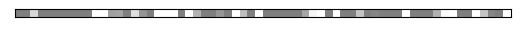

In [22]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


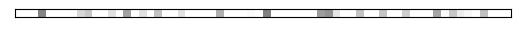

In [23]:
show(make_grid(train_originals.cpu()+0.5))

## View Embedding

In [24]:
! pip uninstall umap
! pip install umap-learn

import umap.umap_ as umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

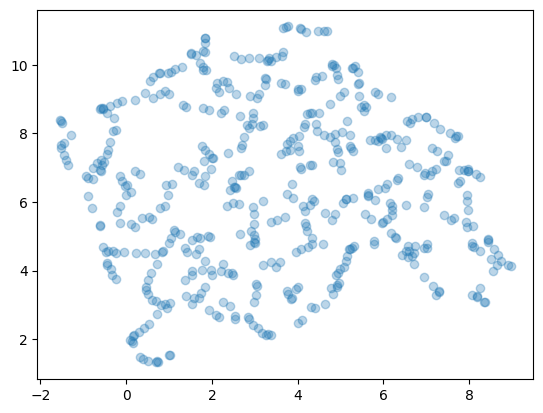

In [25]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)